# SD-TSIA 211
## Computer Lab: Natural Language Processing
Bruno Pons

In [173]:
import numpy as np
import scipy.sparse as sp
from scipy.linalg import norm, solve
from scipy.optimize import check_grad
import matplotlib.pyplot as plt
import time

In [174]:
def load_data(file_name_matrix='tfidf_matrix_97MB.npz', file_name_feature_names='feature_names_97MB.npy',
    file_name_labels='train_labels.npy', samples_in_train_set=10000, samples_in_test_set=137562):
    
    # Recuperation des donnees
    TF_IDF_matrix = sp.load_npz(file_name_matrix)
    TF_IDF_feature_names = np.load(file_name_feature_names)
    train_labels = np.load(file_name_labels, allow_pickle=True)
    train_labels_numeric = ((train_labels == 'Oui') + 0)

    X = TF_IDF_matrix[:samples_in_train_set].toarray()
    y = train_labels_numeric[:samples_in_train_set] * 2 - 1

    X_test = TF_IDF_matrix[samples_in_train_set:samples_in_train_set+samples_in_test_set].toarray()
    y_test = train_labels_numeric[samples_in_train_set:samples_in_train_set+samples_in_test_set] * 2 - 1


    # Standardisation des données
    std_X = np.maximum(np.std(X, axis=0), 1e-7)
    X = X / std_X
    X_test = X_test / std_X

    n = X.shape[0]
    n_test = X_test.shape[0]
    m = X.shape[1]

    # Ajout d'une colonne de uns
    eX = np.hstack((np.ones((n,1)), X))
    eX_test = np.hstack((np.ones((n_test,1)), X_test))

    return eX, y, eX_test, y_test

## Question 3.1

The gradient of $f1$ is:
$\nabla f1\left(w_0, \mathbf{w}\right)=\left(\begin{array}{c}
-\frac{1}{n}\sum_{i=1}^n y_i \sigma\left(-y_i\left(\mathbf{x}_i^{\top} \mathbf{w}+w_0\right)\right) \\
-\frac{1}{n}\sum_{i=1}^n x_{1 i} y_i \sigma\left(-y_i\left(\mathbf{x}_i^{\top} \mathbf{w}+w_0\right)\right)+\rho w_1 \\
\vdots \\
-\frac{1}{n}\sum_{i=1}^n x_{p i} y_i \sigma\left(-y_i\left(\mathbf{x}_i^{\top} \mathbf{w}+w_0\right)\right)+\rho w_p
\end{array}\right)$ with $\sigma(x)=\frac{1}{1+\exp (-x)}$


For calculating the Hessian matrix, we set:

$X = [1,\tilde X] $ where $\tilde X$ is our original matrix.

$w = [w_0 ,\tilde w]$ where $\tilde w$ is our original vector variable.

$z_k:=y_k\left(\mathbf{x}_k^{\top} \mathbf{w}\right)$

For the term i=1 and j=1, we differentiate the first term of the gradient with respect to the first variable, in this case $w_0$, then we have:
$ \partial_{1,1} f\left(w_0, \mathbf{w}\right)=\frac{1}{n}\sum_{k=1}^n y_k^2 e^{z_k} \sigma\left(-z_k\right)^2 $

For the terms i ∈ $[2, p + 1]$ and j = 1 we differentiate the i-th term of the gradient with respect to
the first variable, then we have:
$\forall i \in [ 2, p+1 ], \partial_{i, 1} f\left(w_0, \mathbf{w}\right)=\frac{1}{n}\sum_{k=1}^n x_{i, k} y_k^2 e^{z_k} \sigma\left(-z_k\right)^2$

For the terms i,j ∈ $[2, p + 1]$ , $i \neq j $, we have:

$ \forall i, j \in [ 2, p+1 ], i \neq j , \partial_{i, j} f(\mathbf{x})=\frac{1}{n}\sum_{k=1}^n x_{i, k} x_{j, k} y_k^2 e^{z_k} \sigma\left(-z_k\right)^2 $


For the terms i,j ∈ $[2, p + 1]$, $ i = j $, we have:

$ \forall i, j \in [ 2, p+1 ], i = j , \partial_{i, i} f(\mathbf{x})=\frac{1}{n}\sum_{k=1}^n x_{i, k}^2 y_k^2 e^{z_k} \sigma\left(-z_k\right)^2 + \rho $



We can rewrite what we have before in a general expresion form:

$\nabla^2 f1(w) = \frac{1}{n}\sum_{i=1}^n x_i^T x_i y_i^2 e^{z_k} \sigma\left(-z_i\right)^2 + \rho I_p - \rho A$

Where A is a matrix with all zeros except in position i=1, j=1 it has 1.

As $x_i^T x_i $ is always a PSD matrix, then the hessian matrix is positive semi-definite, so our function is convex.

## Question 3.2

In [175]:
# Load Data
X_load, Y_load, X_test, Y_test = load_data()

X = X_load
Y = Y_load

p = X.shape[1]

Code a function that returns the value of f1 , its gradient and Hessian matrix.

In [176]:

def log_reg(w, _X = X, _Y = Y):
    n= X.shape[0]
    rho = 1/n
    sum = 0
    sum = (1/n) * np.sum( np.log(1 + np.exp(-_Y * (_X @ w))))
    sum += rho/2 * np.linalg.norm(w[:-1], 2)**2
    return sum

def grad_log_reg(w, _X = X, _Y = Y):
    n= X.shape[0]
    rho = 1/n
    sum = 0
    denominator = 1 + np.exp(_Y * (_X @ w))
    sum = (1/n) * np.sum( (-_Y.reshape(len(_Y),1) * _X) / denominator.reshape(len(denominator),1), axis=0 )
    sum += rho * np.concatenate((w[:-1], [0]))
    return sum

def hessian_log_reg(w, _X = X, _Y = Y):
    n= X.shape[0]
    rho = 1/n
    p = X.shape[1]
    A = np.zeros(shape=(p,p))
    A[0,0] = 1
    s = _Y*(_X @ w)
    z = np.exp(s)/(1+np.exp(s))**2
    sum = (1/n) * (z * _X.T) @ _X + rho * (np.eye(p) - A)
    return sum



 Testing using the function check grad on a small-dimensional problem.

In [177]:
Y_small = np.array([-1,1,1,1,-1,-1,-1,1,-1,1])
X_small = np.random.rand(10,3)
w = np.random.rand(3)


start = time.time()
error = check_grad(log_reg, grad_log_reg, w, X_small, Y_small)


print("The time taken for cheking the gradient = ",time.time()-start)
print("The error was = " , error)

The time taken for cheking the gradient =  0.0006492137908935547
The error was =  1.5941612932347704e-12


 Testing using the function check grad on all the data.

In [178]:
p = X.shape[1]
w = np.random.rand(p)


start = time.time()

error = check_grad(log_reg, grad_log_reg, w, X, Y)

print("The time taken for cheking the gradient = ",time.time()-start)
print("The error was = " , error)

The time taken for cheking the gradient =  1.9817848205566406
The error was =  5.196045590409181e-06


In both cases, the square root of the sum of squares of the difference between the gradient and its finite difference approximation is very small, we can conclude that the formulas and computations are coherent.

In [179]:
def check_hessian(grad_func, hessian_func, w):
    return check_grad(lambda x: grad_func(x)[0], lambda x: hessian_func(x)[:,0], w)

In [180]:
check_hessian(grad_log_reg, hessian_log_reg, w)

9.999954308947177e-05

The Hessian function seems to be working.

## Question 3.3

In [181]:
def newton_method(x0, eps = 1e-10, max_iter = 50):
    x = x0
    _iter = 0
    norm_arr = []
    grad = grad_log_reg(x)
    hessian = hessian_log_reg(x)
    norm = np.linalg.norm(grad,2)
    norm_arr.append(norm)
    
    while (norm > eps) & (_iter <= max_iter):
        _iter += 1
        next_dir = np.linalg.inv(hessian) @ grad
        x = x - next_dir
        grad = grad_log_reg(x)
        hessian = hessian_log_reg(x)
        norm = np.linalg.norm(grad,2)
        norm_arr.append(norm)

    
    return x, norm_arr
        

In [182]:
w = np.zeros(p)

out_n, norm_arr = newton_method(w)

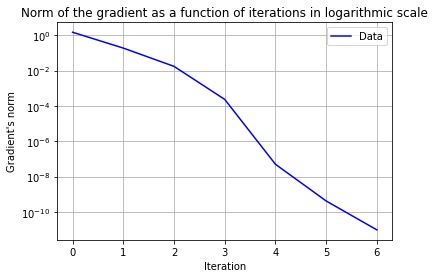

The minimizer value is =  0.5681166336576328


In [183]:
fig, ax = plt.subplots()
plt.plot(norm_arr, color="b")
plt.xlabel("Iteration")
plt.ylabel("Gradient's norm")
ax.set_yscale("log")
ax.legend(["Data"])
plt.title("Norm of the gradient as a function of iterations in logarithmic scale")
plt.grid()
plt.show()

print("The minimizer value is = ", log_reg(out_n))

## Question 3.4

In [184]:
w = np.full(p, 1)

out, norm_arr = newton_method(w)

/tmp/ipykernel_145561/3466041047.py:25: RuntimeWarning: overflow encountered in square
  z = np.exp(s)/(1+np.exp(s))**2
/tmp/ipykernel_145561/3466041047.py:13: RuntimeWarning: overflow encountered in exp
  denominator = 1 + np.exp(_Y * (_X @ w))
/tmp/ipykernel_145561/3466041047.py:25: RuntimeWarning: overflow encountered in exp
  z = np.exp(s)/(1+np.exp(s))**2
/tmp/ipykernel_145561/3466041047.py:25: RuntimeWarning: invalid value encountered in true_divide
  z = np.exp(s)/(1+np.exp(s))**2


In [185]:
out[0:5]

array([nan, nan, nan, nan, nan])

What is happening is that the initial point is not close enough to the local minimum, so as seen in the theory the Newton's method diverges. In order to solve this we must combine Newton's method with line search, this is what we are going to implement in part 3.5.

## Question 3.5

Armijo's line search, as to make sure that the line search selects γk = 1 when possible in order to keep the
quadratic convergence, we chose a=0,5 and b=1 by default.

In [186]:
def armijo_line(x, _grad, _next_dir, _a=1/2, _b=1, _beta = 1/2):
    l = 0
    _gamma = _b*_a**l
    x_plus = x - _gamma*_next_dir
    while log_reg(x_plus) > log_reg(x) + _beta* (_grad @ (x_plus-x)) :
        l += 1
        _gamma = _b*_a**l
        x_plus = x - _gamma*_next_dir
    return l

In [187]:
def newton_armijo_method(x0, eps = 1e-10, max_iter = 50):
    x = x0
    _iter = 0
    a, b , beta = 1/2, 1, 1/2
    gamma = 1
    norm_arr = []
    grad = grad_log_reg(x)
    hessian = hessian_log_reg(x)
    norm = np.linalg.norm(grad,2)
    norm_arr.append(norm)
    
    while (norm > eps) & (_iter <= max_iter):
        _iter += 1
        next_dir = np.linalg.inv(hessian) @ grad
        gamma = b * a**armijo_line(x, grad, next_dir)
        x = x - gamma*next_dir
        grad = grad_log_reg(x)
        hessian = hessian_log_reg(x)
        norm = np.linalg.norm(grad,2)
        norm_arr.append(norm)

    
    return x, norm_arr

In [188]:
#
# Choose the starting point
#

w = np.zeros(p)
#w = np.full(p, 1)

out_n_a, norm_arr = newton_armijo_method(w)

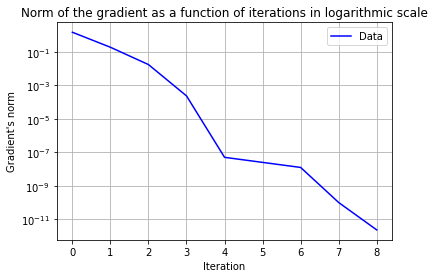

The minimizer value is =  0.5681166336576327


In [189]:
fig, ax = plt.subplots()
plt.plot(norm_arr, color="b")
plt.xlabel("Iteration")
plt.ylabel("Gradient's norm")
ax.set_yscale("log")
ax.legend(["Data"])
plt.title("Norm of the gradient as a function of iterations in logarithmic scale")
plt.grid()
plt.show()

print("The minimizer value is = ", log_reg(out_n_a))

With this approach the Newton's method manages to converge.

# Part 4

## Question 4.1

We can't use Newton's method to solve this problem because the regularizer is not differentiable.

## Question 4.2

$\min _{w_0 \in \mathbb{R}, w \in \mathbb{R}^p} \frac{1}{n} \sum_{i=1}^n \log \left(1+\exp \left(-y_i\left(x_i^{\top} w+w_0\right)\right)\right)+\rho\|w\|_1$

The objective function can be written as $F_2 = f_2 + g_2$ where $f_2 = \frac{1}{n} \sum_{i=1}^n \log \left(1+\exp \left(-y_i\left(x_i^{\top} w+w_0\right)\right)\right)$ and $g_2 = \rho\|w\|_1$.

$\mathrm{prox}_{g}(x) = \mathrm{argmin}_{y \in \mathbb{R}^p}  \ {g(y) + \frac{1}{2} \| y -x \|^2 } $

In our case we can write proximal as follows $\mathrm{prox}_{g_2}(x) = \Big(\mathrm{sgn}(x_i) \max(|x_i| - \rho,0)\Big)_{i\in \{1,...,p\} }$

Similarly as calculated before, the gradient of $f_2$ is:
$\nabla f_2\left(w_0, \mathbf{w}\right)=\left(\begin{array}{c}
-\frac{1}{n}\sum_{i=1}^n y_i \sigma\left(-y_i\left(\mathbf{x}_i^{\top} \mathbf{w}+w_0\right)\right) \\
-\frac{1}{n}\sum_{i=1}^n x_{1 i} y_i \sigma\left(-y_i\left(\mathbf{x}_i^{\top} \mathbf{w}+w_0\right)\right) \\
\vdots \\
-\frac{1}{n}\sum_{i=1}^n x_{p i} y_i \sigma\left(-y_i\left(\mathbf{x}_i^{\top} \mathbf{w}+w_0\right)\right)
\end{array}\right)$ with $\sigma(x)=\frac{1}{1+\exp (-x)}$

## Question 4.3

In [190]:
def f2(w, _X = X, _Y = Y):
    n= X.shape[0]
    sum = 0
    sum = (1/n) * np.sum( np.log(1 + np.exp(-_Y * (_X @ w))))
    return sum

def grad_f2(w, _X = X, _Y = Y):
    n= X.shape[0]
    sum = 0
    denominator = 1 + np.exp(_Y * (_X @ w))
    sum = (1/n) * np.sum( (-_Y.reshape(len(_Y),1) * _X) / denominator.reshape(len(denominator),1), axis=0 )
    return sum

In [191]:
check_grad(f2, grad_f2, np.random.rand(X.shape[1]))

4.463432466332193e-06

In [192]:
#Define Line Search Method

def line_search(x, _grad, _a=1/2, _b=1, _beta = 1/2):
    l = 0
    _gamma = _b*_a**l
    x_plus = x - _gamma*_grad
    while f2(x_plus) > f2(x) + _beta* (_grad @ (x_plus-x)) :
        l += 1
        _gamma = _b*_a**l
        x_plus = x - _gamma*_grad
    return l

In [193]:
# Define proximal gradient method

def prox_grad(x0, eps = 1e-5, max_iter = 100):
    x = x0
    arr_zeros = np.zeros(x.shape)
    _iter = 0
    rho = 0.02
    norm_arr = []
    a, b , beta = 1/2, 1, 1/2
    grad = grad_f2(x)
    norm = np.linalg.norm(grad,2)
    norm_arr.append(norm)
    
    while (norm > eps) & (_iter <= max_iter):
        _iter += 1
        gamma = b * a**line_search(x, grad)
        xi = x - gamma*grad
        x = np.sign(xi)*np.maximum(np.abs(xi)-rho*gamma,arr_zeros)
        grad = grad_f2(x)
        norm = np.linalg.norm(grad,2)
        norm_arr.append(norm)

    
    return x, norm_arr



In [194]:
#
# Choose what initial point to use
#

#w = np.full(p,1)
w = np.zeros(p)

out_prox, norm_arr = prox_grad(w)

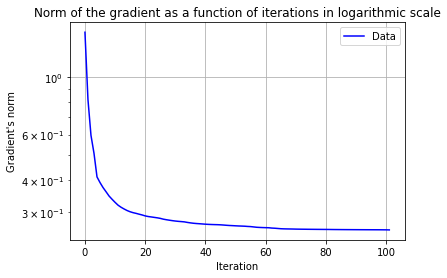

The minimizer value is =  0.6290119123978519


In [195]:
fig, ax = plt.subplots()
plt.plot(norm_arr, color="b")
plt.xlabel("Iteration")
plt.ylabel("Gradient's norm")
ax.set_yscale("log")
ax.legend(["Data"])
plt.title("Norm of the gradient as a function of iterations in logarithmic scale")
plt.grid()
plt.show()

print("The minimizer value is = ", f2(out_prox))